### 포트홀(pothole) 탐지 모델

#### 데이터셋 다운로드
- 포트홀 데이터셋: https://public.roboflow.com/object-detection/pothole

In [ ]:
%mkdir yolov5/pothole
%cd yolov5/pothole
!curl -L "https://public.roboflow.com/ds/n54PyMjyOL?key=GSCRboJ7L3" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
%cd ../..

In [13]:
from glob import glob

train_image_list = glob("yolov5/pothole/train/images/*.jpg")
test_image_list = glob("yolov5/pothole/test/images/*.jpg")
valid_image_list = glob("yolov5/pothole/valid/images/*.jpg")

print(len(train_image_list), len(test_image_list), len(valid_image_list))

465 67 133


In [14]:
import yaml

with open("yolov5/pothole/train.txt", "w") as f:
    f.write("\n".join(train_image_list) + "\n")

with open("yolov5/pothole/test.txt", "w") as f:
    f.write("\n".join(test_image_list) + "\n")

with open("yolov5/pothole/valid.txt", "w") as f:
    f.write("\n".join(valid_image_list) + "\n")

In [15]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def write_template(line, cell):
    with open(line, "w") as f:
        f.write(cell.format(**globals()))

In [16]:
%cat yolov5/pothole/data.yaml

train: ../train/images
val: ../valid/images

nc: 1
names: ['pothole']

In [17]:
%%write_template yolov5/pothole/data.yaml

train: ./pothole/train/images
test: ./pothole/test/images
val: ./pothole/valid/images

nc: 1
names: ['pothole']

In [18]:
%cat yolov5/pothole/data.yaml


train: ./pothole/train/images
test: ./pothole/test/images
val: ./pothole/valid/images

nc: 1
names: ['pothole']


#### 모델 구성

In [19]:
import yaml

with open("yolov5/pothole/data.yaml", "r") as stream:
    num_classes = str(yaml.safe_load(stream)["nc"])

%cat yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [20]:
%%write_template yolov5/models/custom_yolov5.yaml

# Parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [21]:
%cat yolov5/models/custom_yolov5.yaml


# Parameters
nc: 1  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, Fa

#### 학습(Training)
- img: 입력 이미지 크기 정의
- batch: 배치 크기 정의
- epochs: 학습 횟수 정의
- data: yaml 파일 경로
- cfg: 모델 구성 지정
- weights: 가중치에 대한 경로 지정
- name: 결과 이름
- nosave: 최종 체크포인트만 저장
- cache: 빠른 학습을 위한 이미지 캐시

In [ ]:
%time
%cd yolov5
!python train.py --img 640 --batch 32 --epochs 100 --data ./pothole/data.yaml --cfg ./models/custom_yolov5.yaml --weights "" --name pothole_results --cache 

In [28]:
!ls runs/train/pothole_results

F1_curve.png
PR_curve.png
P_curve.png
R_curve.png
confusion_matrix.png
events.out.tfevents.1652072932.194925e1a31b.327.0
hyp.yaml
labels.jpg
labels_correlogram.jpg
opt.yaml
results.csv
results.png
train_batch0.jpg
train_batch1.jpg
train_batch2.jpg
val_batch0_labels.jpg
val_batch0_pred.jpg
val_batch1_labels.jpg
val_batch1_pred.jpg
val_batch2_labels.jpg
val_batch2_pred.jpg
weights


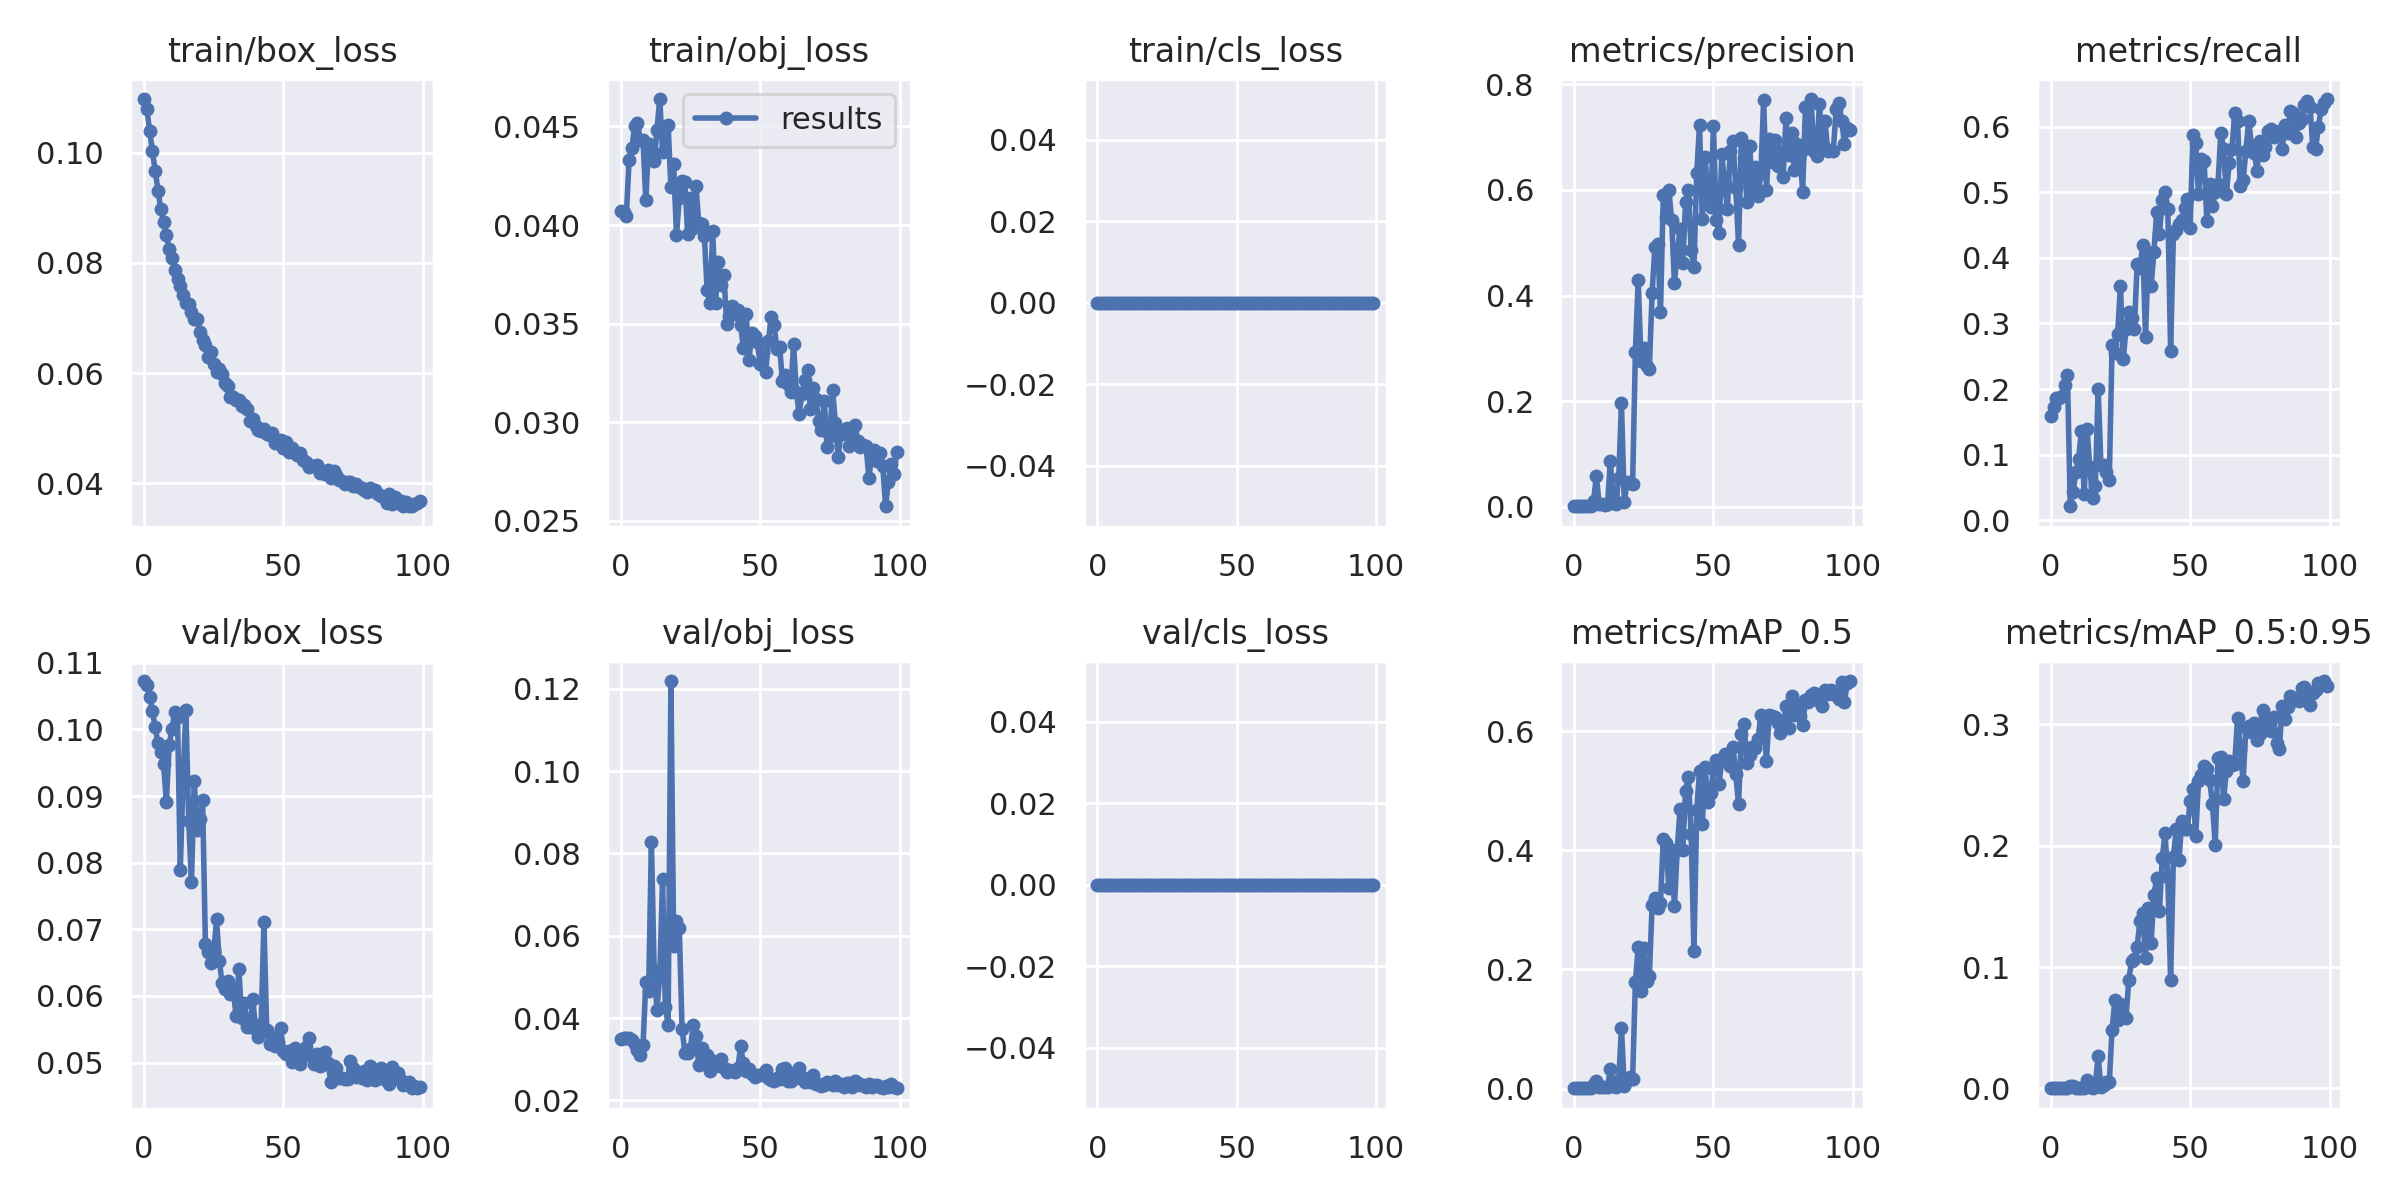

In [39]:
from IPython.display import Image

Image(filename="runs/train/pothole_results/results.png", width=800)

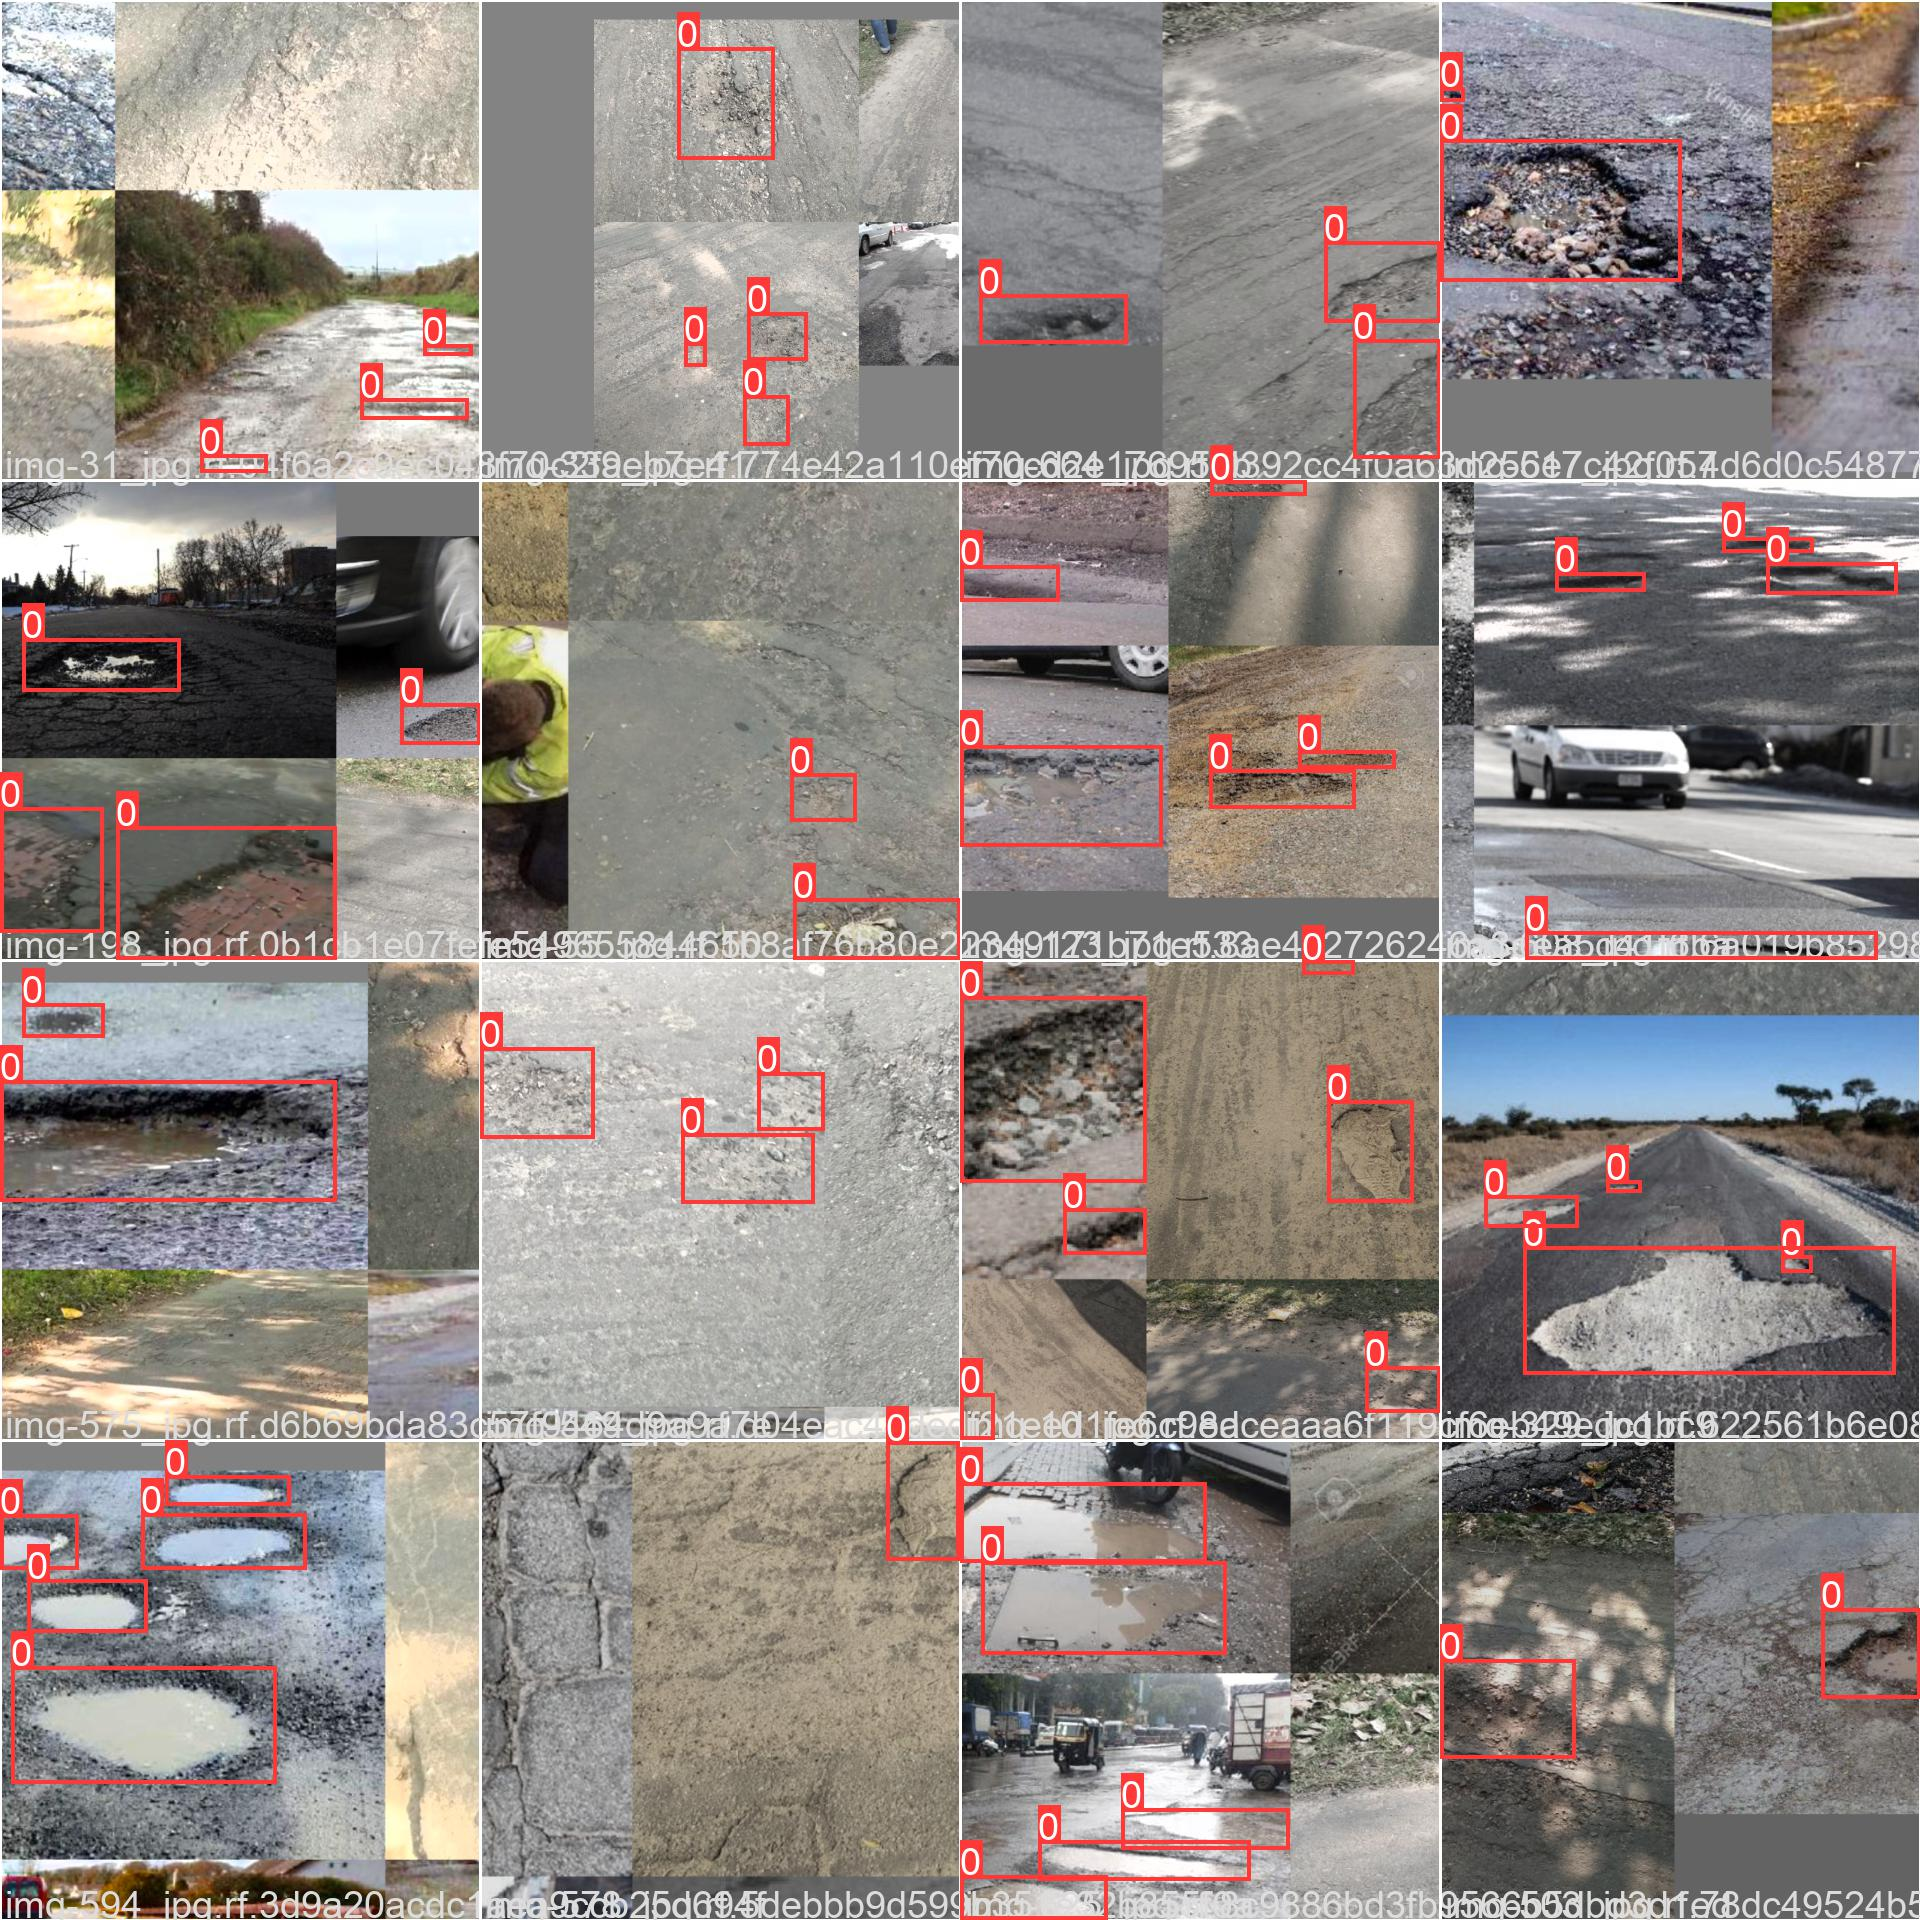

In [40]:
Image(filename="runs/train/pothole_results/train_batch0.jpg", width=800)

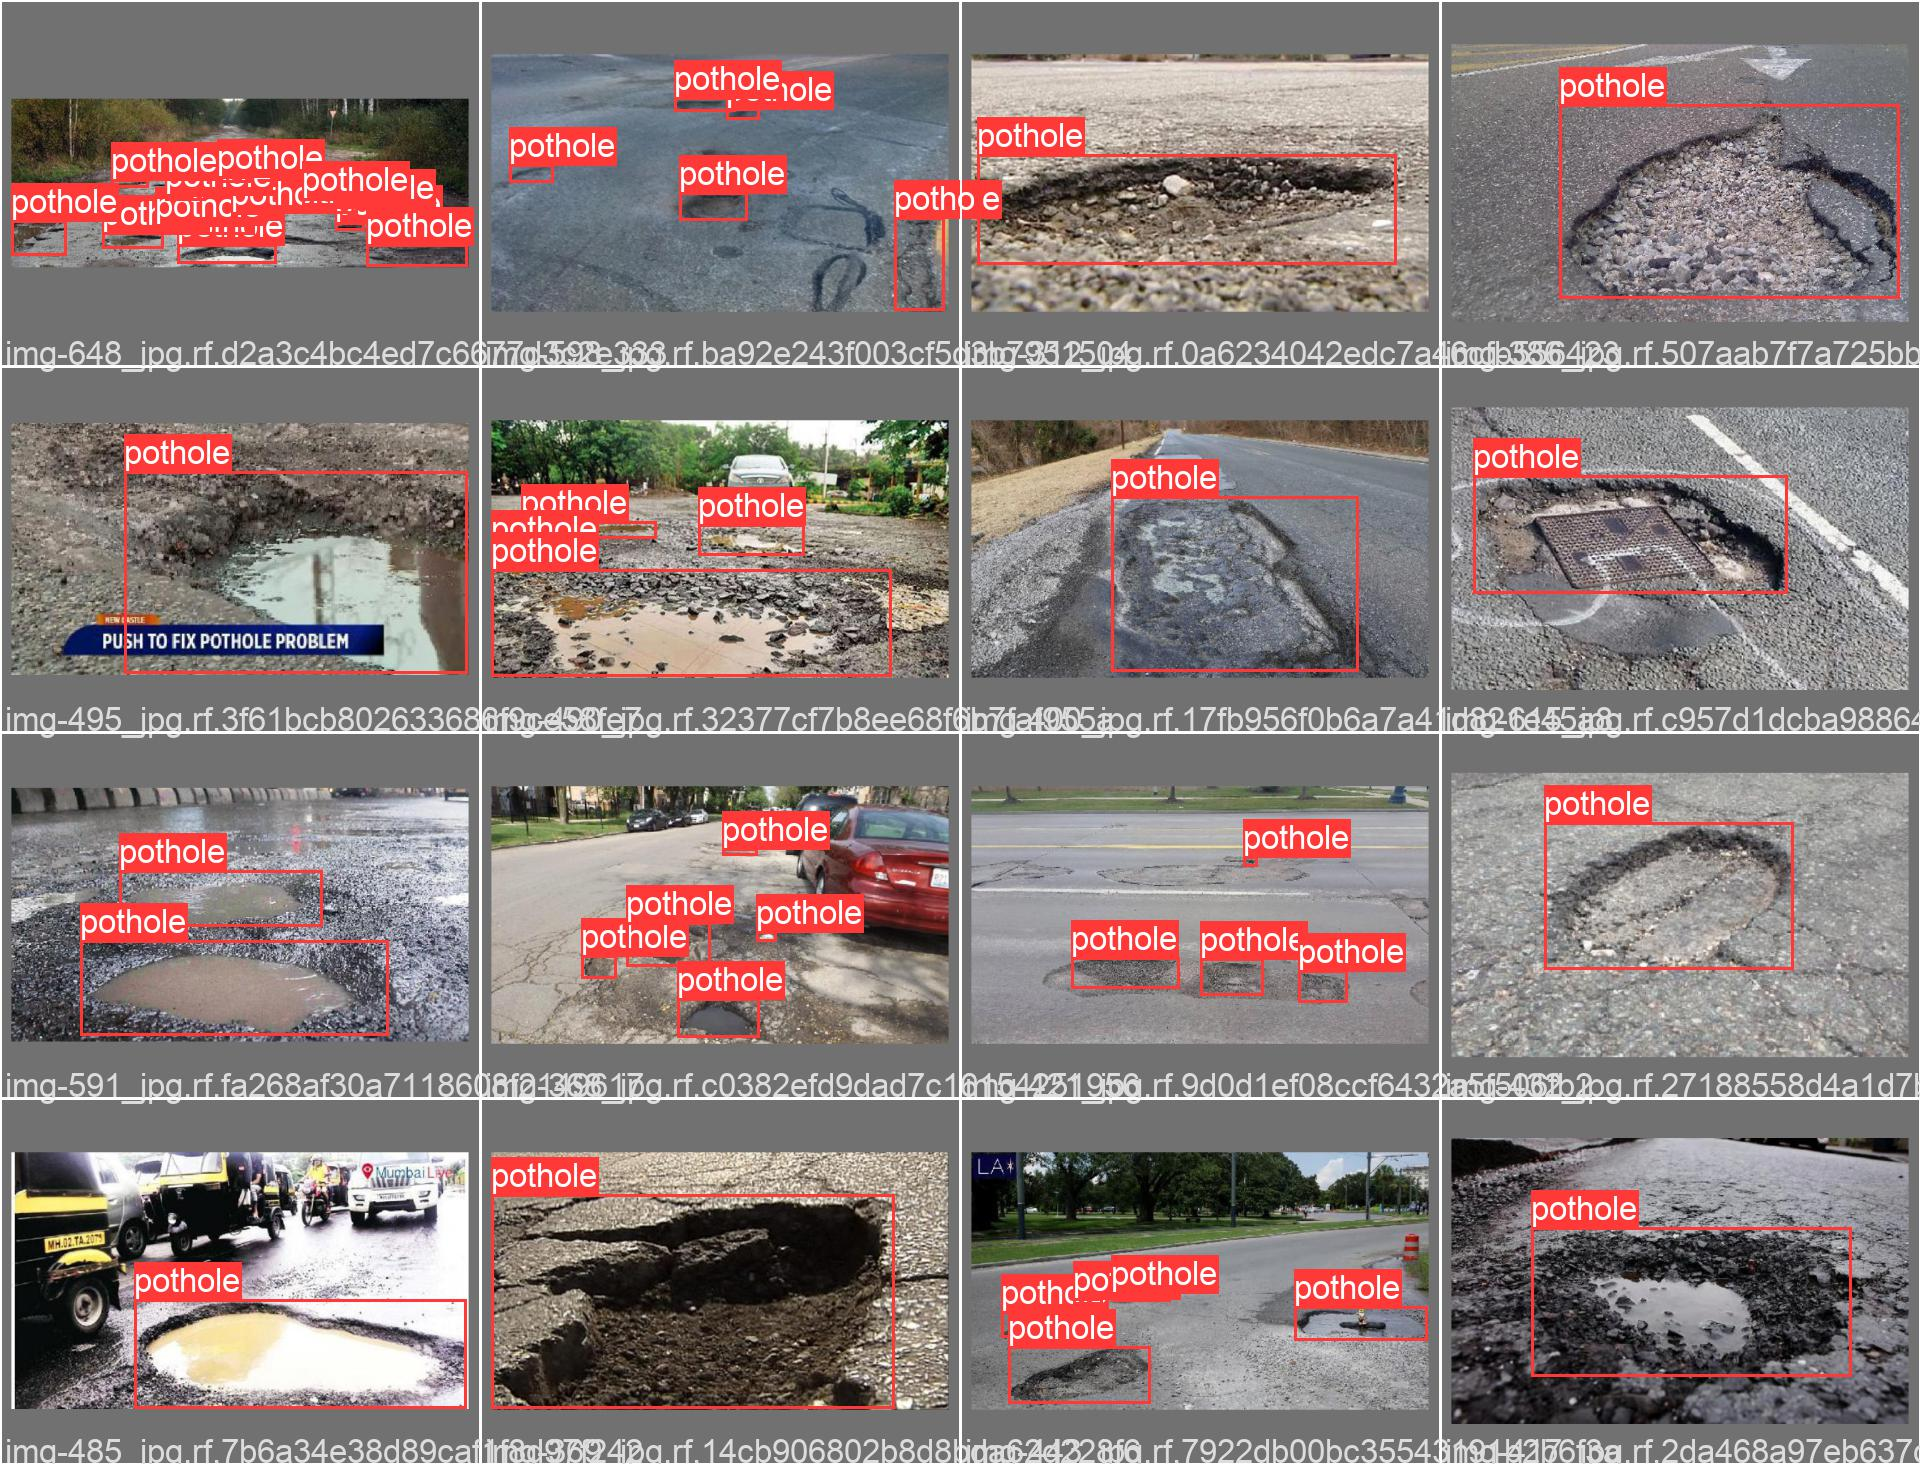

In [41]:
Image(filename="runs/train/pothole_results/val_batch0_labels.jpg", width=800)

#### 검증(Validation)

In [ ]:
!python val.py --weights runs/train/pothole_results/weights/best.pt --data pothole/data.yaml --img 640 --iou 0.65 --half

In [ ]:
!python val.py --weights runs/train/pothole_results/weights/best.pt --data pothole/data.yaml --img 640 --task test

#### 추론(Inference)

In [46]:
!ls runs/train/pothole_results/weights

best.pt last.pt


In [45]:
!python detect.py --weights runs/train/pothole_results/weights/best.pt --img 640 --conf 0.4 --source pothole/test/images

detect: weights=['runs/train/pothole_results/weights/best.pt'], source=pothole/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-177-gd059d1d torch 1.11.0 CPU

Fusing layers... 
custom_YOLOv5 summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/67 /Users/csh/programming_language/001_Python/02_computervision/recipes/object_detection/yolov5/pothole/test/images/img-105_jpg.rf.3fe9dff3d1631e79ecb480ff403bcb86.jpg: 640x640 1 pothole, Done. (0.396s)
image 2/67 /Users/csh/programming_language/001_Python/02_computervision/recipes/object_detection/yolov5/pothole/test/images/img-107_jpg.rf.2e40485785f6e5e2efec404301b235c2.jp

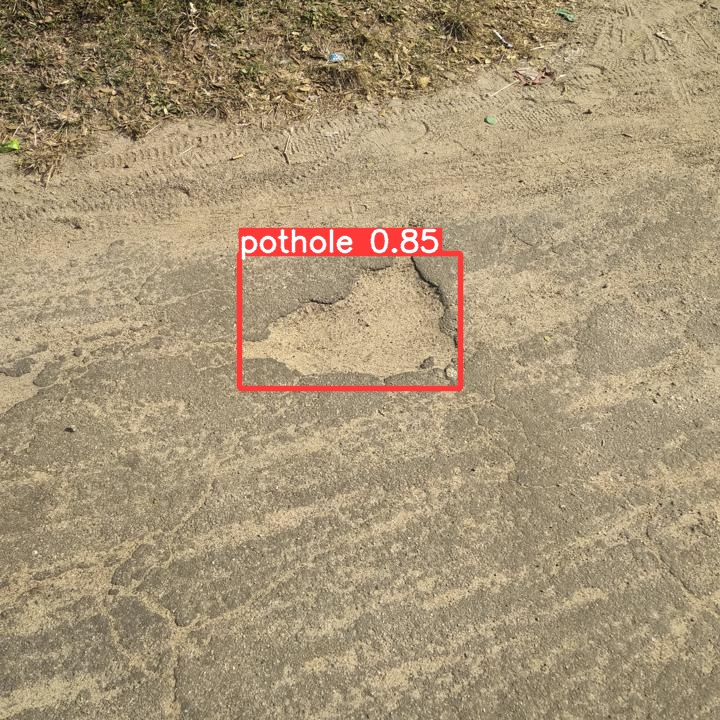

In [47]:
import glob
import random
from IPython.display import Image, display

image_name = random.choice(glob.glob("runs/detect/exp2/*.jpg"))
display(Image(filename=image_name))